In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# 1) Load feature-engineered style data
styles = pd.read_csv("/kaggle/input/combined/FeatureEngineered_StyleData.csv")

# 2) Load image embeddings + ids
img_embs = np.load("/kaggle/input/combined/image_embeddings_clip.npy")   # shape: (N, 512)
img_ids = pd.read_csv("/kaggle/input/combined/image_embeddings_ids.csv")["id"].astype(int).values

print("styles shape:", styles.shape)
print("image embs shape:", img_embs.shape)
print("image ids:", img_ids.shape)

styles shape: (43575, 52)
image embs shape: (44446, 512)
image ids: (44446,)


In [8]:
common_ids = np.intersect1d(styles["id"].astype(int).values, img_ids)

In [9]:
common_ids

array([ 1163,  1164,  1165, ..., 59998, 59999, 60000])

In [10]:
len(common_ids)

43575

In [11]:
styles = styles[styles["id"].isin(common_ids)].copy()
styles["id"] = styles["id"].astype(int)

In [12]:
# reindex image embeddings to match styles order
id_to_idx = {int(i): idx for idx, i in enumerate(img_ids)}
img_embs_aligned = np.stack([img_embs[id_to_idx[i]] for i in styles["id"].values])

In [13]:
print("After alignment:")
print("styles:", styles.shape)
print("aligned image embs:", img_embs_aligned.shape)

After alignment:
styles: (43575, 52)
aligned image embs: (43575, 512)


In [14]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# L2-normalize embeddings for cosine similarity
img_embs_norm = normalize(img_embs_aligned)


In [16]:
# quick helper
id_to_row = {pid: idx for idx, pid in enumerate(styles["id"].values)}

In [17]:
def recommend_by_image(product_id, topn=10):
    if product_id not in id_to_row:
        raise ValueError(f"Product id {product_id} not found.")
    i = id_to_row[product_id]
    query_vec = img_embs_norm[i].reshape(1, -1)
    sims = cosine_similarity(query_vec, img_embs_norm).ravel()

    # sort by similarity (high → low), skip self
    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order][[
        "id", "brandName", "productDisplayName" if "productDisplayName" in styles.columns else "articleType",
        "baseColour", "effective_price", "price_bucket"
    ]].copy()
    recs["similarity_img"] = sims[order]
    return recs

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

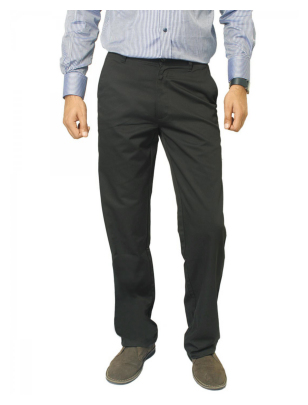

In [19]:
show_image("/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12222.jpg")

In [20]:
recommend_by_image(12222)

,id,brandName,articleType,baseColour,effective_price,price_bucket,similarity_img
1848,12212,Basics,Trousers,brown,899.0,mid,0.935792
1855,12219,Basics,Trousers,green,1549.0,mid,0.920456
13649,26155,John Miller,Trousers,gray,1599.0,high,0.911702
14507,27181,Mark Taylor,Trousers,blue,779.0,mid,0.907349
14511,27185,Mark Taylor,Trousers,brown,779.0,mid,0.904320
13645,26151,John Miller,Trousers,navy,1099.0,mid,0.903128
5063,16019,Turtle,Trousers,gray,1595.0,mid,0.902311
3180,13782,Belmonte,Trousers,black,1245.0,mid,0.902031
1907,12290,Genesis,Trousers,black,1699.0,high,0.902008
13656,26162,John Miller,Trousers,black,1599.0,high,0.901213


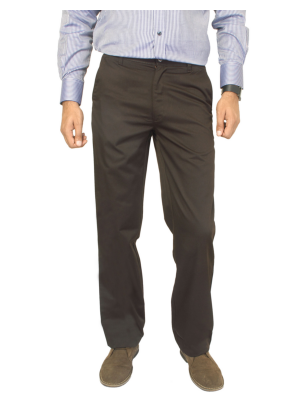

In [21]:
show_image("/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12212.jpg")

In [22]:
num_cols = [
    "log_effective_price", "discount_ratio", "myntraRating",
    "vat", "num_style_options", "total_inventoryCount",
    "category_strength", "isEMIEnabled", "isFragile", "isTryAndBuyEnabled",
    "isHazmat", "isJewellery", "isReturnable", "isExchangeable",
    "pickupEnabled", "isLarge", "codEnabled", "any_in_stock",
    "has_image", "is_discounted"
]
num_cols = [c for c in num_cols if c in styles.columns]

# Categorical (will be one-hot encoded)
cat_cols = [
    "brandName", "ageGroup", "gender", "baseColour", "colour1",
    "fashionType", "season_group" if "season_group" in styles.columns else "season",
    "usage", "masterCategory", "subCategory", "articleType",
    "articleAttr_Pattern", "articleAttr_Body_or_Garment_Size",
    "articleAttr_Fit", "articleAttr_Sleeve_Length", "articleAttr_Neck",
    "articleAttr_Fabric", "articleAttr_Occasion", "articleAttr_Type",
    "displayCat_primary", "price_bucket", "era", "segment"
]
cat_cols = [c for c in cat_cols if c in styles.columns]

# Text column for TF-IDF
text_col = "style_signature" if "style_signature" in styles.columns else None


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

In [24]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


In [25]:
meta_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [26]:
X_meta = meta_preprocessor.fit_transform(styles)
print("X_meta shape:", X_meta.shape)

X_meta shape: (43575, 1024)


In [27]:
if text_col:
    tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
    X_text = tfidf.fit_transform(styles[text_col].fillna(""))
    
    svd = TruncatedSVD(n_components=64, random_state=42)
    X_text_red = svd.fit_transform(X_text)       # dense (N, 64)
    X_text_red = csr_matrix(X_text_red)          # make sparse for hstack
    print("X_text_red shape:", X_text_red.shape)
else:
    X_text_red = None


X_text_red shape: (43575, 64)


In [28]:
if X_text_red is not None:
    X_meta_text = hstack([X_meta, X_text_red])
else:
    X_meta_text = X_meta

In [29]:
print("X_meta_text shape:", X_meta_text.shape)

X_meta_text shape: (43575, 1088)


In [30]:
X_meta_text

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4618950 stored elements and shape (43575, 1088)>

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_by_meta(product_id, topn=10):
    if product_id not in id_to_row:
        raise ValueError(f"Product id {product_id} not found.")
    i = id_to_row[product_id]
    query_vec = X_meta_text[i]
    sims = cosine_similarity(query_vec, X_meta_text).ravel()

    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order][[
        "id", "brandName", 
        "productDisplayName" if "productDisplayName" in styles.columns else "articleType",
        "baseColour", "effective_price", "price_bucket"
    ]].copy()
    recs["similarity_meta"] = sims[order]
    return recs

In [32]:
recommend_by_meta(11111)

,id,brandName,articleType,baseColour,effective_price,price_bucket,similarity_meta
863,11110,Indigo Nation,Shirts,white,1199.0,mid,0.984391
43282,9642,Indigo Nation,Shirts,white,1049.0,mid,0.964342
43273,9633,Indigo Nation,Shirts,white,1049.0,mid,0.964342
43254,9611,Indigo Nation,Shirts,white,1049.0,mid,0.952455
865,11112,Indigo Nation,Shirts,white,1199.0,mid,0.948547
42545,8789,Indigo Nation,Shirts,white,999.0,mid,0.927491
42548,8792,Indigo Nation,Shirts,white,999.0,mid,0.927491
866,11113,Indigo Nation,Shirts,white,1499.0,mid,0.923825
43256,9613,Indigo Nation,Shirts,white,1049.0,mid,0.917508
43275,9635,Indigo Nation,Shirts,white,1049.0,mid,0.917508


In [33]:
def recommend_hybrid(product_id, topn=10, alpha=0.6):
    """
    alpha = weight for image similarity
    (1 - alpha) = weight for meta+text similarity
    """
    if product_id not in id_to_row:
        raise ValueError(f"Product id {product_id} not found.")
    i = id_to_row[product_id]

    # image sim
    img_sim = cosine_similarity(
        img_embs_norm[i].reshape(1, -1),
        img_embs_norm
    ).ravel()

    # meta+text sim
    meta_sim = cosine_similarity(
        X_meta_text[i],
        X_meta_text
    ).ravel()

    # hybrid similarity
    sims = alpha * img_sim + (1 - alpha) * meta_sim

    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order][[
        "id", "brandName", 
        "productDisplayName" if "productDisplayName" in styles.columns else "articleType",
        "baseColour", "effective_price", "price_bucket"
    ]].copy()
    recs["similarity_hybrid"] = sims[order]
    recs["similarity_img"] = img_sim[order]
    recs["similarity_meta"] = meta_sim[order]
    return recs


In [34]:
recommend_hybrid(10000, topn=10, alpha=0.6)

,id,brandName,articleType,baseColour,effective_price,price_bucket,similarity_hybrid,similarity_img,similarity_meta
972,11260,Palm Tree,Skirts,green,324.0,low,0.870760,0.818006,0.949890
32435,5005,Gini and Jony,Skirts,red,349.0,low,0.817949,0.762938,0.900466
2,10002,Palm Tree,Skirts,blue,274.0,low,0.811722,0.703686,0.973775
43570,9995,Gini and Jony,Skirts,pink,359.0,low,0.798185,0.697267,0.949562
1,10001,Palm Tree,Skirts,blue,274.0,low,0.792338,0.671380,0.973775
2803,13339,Gini and Jony,Skirts,black,349.0,low,0.788824,0.729711,0.877495
24019,39330,Gini and Jony,Skirts,white,359.0,low,0.778937,0.712405,0.878736
43569,9994,Gini and Jony,Skirts,blue,449.0,low,0.777634,0.701527,0.891794
2769,13305,Gini and Jony,Skirts,red,359.0,low,0.773897,0.719462,0.855548
2768,13304,Gini and Jony,Skirts,red,349.0,low,0.773019,0.719462,0.853353


In [35]:
from sklearn.cluster import MiniBatchKMeans

k = 30   # you can try 20, 30, 40
kmeans = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    batch_size=2048,
    max_iter=100
)

cluster_labels = kmeans.fit_predict(X_meta_text)
styles["cluster_meta"] = cluster_labels

styles["cluster_meta"].value_counts().head()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_meta
5     2975
10    2707
28    2637
1     2615
15    2561
Name: count, dtype: int64

In [36]:
for c in range(k):
    print("Cluster:", c)
    display(
        styles[styles.cluster_meta == c][[
            "brandName",
            "articleType",
            "subCategory",
            "baseColour",
            "season_group",
            "usage",
            "price_bucket"
        ]].head(10)
    )
    print("\n" + "-"*80 + "\n")

Cluster: 0


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4336,United Colors of Benetton,Duffel Bag,Bags,black,warm,casual,mid
4423,ADIDAS Originals,Duffel Bag,Bags,blue,cold,casual,high
7911,Puma,Duffel Bag,Bags,black,warm,casual,high
8074,Domyos,Duffel Bag,Bags,gray,warm,casual,mid
8526,Wildcraft,Duffel Bag,Bags,blue,cold,casual,mid
8559,Nike,Duffel Bag,Bags,black,cold,casual,high
9434,Fastrack,Duffel Bag,Bags,navy,cold,casual,mid
9599,Quiksilver,Duffel Bag,Bags,black,warm,casual,high
9600,Quiksilver,Duffel Bag,Bags,black,warm,casual,high
9629,Skybags,Duffel Bag,Bags,black,warm,casual,low



--------------------------------------------------------------------------------

Cluster: 1


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
166,Murcia,Handbags,Bags,green,cold,casual,mid
167,Murcia,Handbags,Bags,brown,cold,casual,mid
168,Murcia,Handbags,Bags,beige,cold,casual,mid
169,Murcia,Handbags,Bags,black,cold,casual,mid
170,Murcia,Handbags,Bags,beige,cold,casual,mid
171,Murcia,Handbags,Bags,green,cold,casual,mid
172,Murcia,Handbags,Bags,red,cold,casual,mid
173,Murcia,Handbags,Bags,purple,cold,casual,mid
174,Murcia,Handbags,Bags,brown,cold,casual,mid
175,Murcia,Handbags,Bags,brown,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 2


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
3,Nike,Tshirts,Topwear,white,cold,sports,high
25,Nike,Tshirts,Topwear,pink,cold,sports,high
34,Nike,Tshirts,Topwear,black,cold,sports,high
582,Nike,Tshirts,Topwear,orange,cold,casual,mid
584,Nike,Tshirts,Topwear,blue,cold,casual,mid
594,Nike,Tshirts,Topwear,white,warm,casual,mid
688,Wrangler,Tshirts,Topwear,gray,cold,casual,mid
693,Wrangler,Tshirts,Topwear,navy,cold,casual,mid
1088,United Colors of Benetton,Tshirts,Topwear,maroon,cold,casual,mid
1092,United Colors of Benetton,Tshirts,Topwear,red,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 3


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
2018,Timberland,Shoe Accessories,Shoe Accessories,brown,cold,unknown,low
2019,Timberland,Shoe Accessories,Shoe Accessories,tan,cold,unknown,low
2020,Timberland,Shoe Accessories,Shoe Accessories,brown,cold,unknown,low
2021,Timberland,Shoe Accessories,Shoe Accessories,white,cold,unknown,low
2022,Timberland,Shoe Accessories,Shoe Accessories,orange,cold,unknown,low
2843,Timberland,Shoe Accessories,Shoe Accessories,black,cold,unknown,low
7129,DAVID BECKHAM,Deodorant,Fragrance,white,warm,casual,low
7130,DAVID BECKHAM,Deodorant,Fragrance,white,warm,casual,low
7132,DAVID BECKHAM,Deodorant,Fragrance,white,warm,casual,low
7133,DAVID BECKHAM,Deodorant,Fragrance,white,warm,casual,low



--------------------------------------------------------------------------------

Cluster: 4


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
46,Puma,Tshirts,Topwear,black,cold,casual,low
54,Puma,Tshirts,Topwear,black,cold,casual,low
65,Puma,Tshirts,Topwear,black,cold,casual,low
401,Flying Machine,Tshirts,Topwear,gray,cold,casual,low
402,Flying Machine,Tshirts,Topwear,yellow,cold,casual,low
404,Flying Machine,Tshirts,Topwear,pink,cold,casual,low
421,Flying Machine,Tshirts,Topwear,purple,cold,casual,low
432,Flying Machine,Tshirts,Topwear,pink,cold,casual,low
466,Puma,Tshirts,Topwear,black,cold,casual,low
467,Puma,Tshirts,Topwear,white,cold,casual,low



--------------------------------------------------------------------------------

Cluster: 5


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
106,Rockport,Casual Shoes,Shoes,brown,cold,casual,high
107,Rockport,Formal Shoes,Shoes,brown,cold,formal,high
119,Rockport,Casual Shoes,Shoes,brown,cold,casual,high
120,Rockport,Formal Shoes,Shoes,brown,cold,formal,high
121,Rockport,Formal Shoes,Shoes,black,cold,formal,high
123,Rockport,Casual Shoes,Shoes,brown,cold,casual,high
125,Rockport,Formal Shoes,Shoes,black,cold,formal,high
126,Rockport,Formal Shoes,Shoes,black,cold,formal,high
127,Rockport,Casual Shoes,Shoes,black,cold,casual,high
128,Rockport,Formal Shoes,Shoes,brown,cold,formal,high



--------------------------------------------------------------------------------

Cluster: 6


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
488,ESPRIT,Free Gifts,Free Gifts,gray,cold,casual,high
938,ESPRIT,Free Gifts,Free Gifts,steel,cold,casual,high
2300,Mother Earth,Kurta Sets,Apparel Set,brown,cold,ethnic,high
2301,Mother Earth,Kurta Sets,Apparel Set,black,cold,ethnic,high
3788,United Colors of Benetton,Stockings,Bottomwear,gray,warm,casual,mid
3789,United Colors of Benetton,Stockings,Bottomwear,black,warm,casual,mid
3790,United Colors of Benetton,Stockings,Bottomwear,black,warm,casual,mid
3791,United Colors of Benetton,Stockings,Bottomwear,purple,warm,casual,mid
3792,United Colors of Benetton,Stockings,Bottomwear,black,warm,casual,mid
3812,United Colors of Benetton,Stockings,Bottomwear,gray,warm,casual,mid



--------------------------------------------------------------------------------

Cluster: 7


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4031,United Colors of Benetton,Sunglasses,Eyewear,purple,cold,casual,high
4074,United Colors of Benetton,Sunglasses,Eyewear,brown,cold,casual,mid
4075,United Colors of Benetton,Sunglasses,Eyewear,blue,cold,casual,mid
5124,Mayhem,Sunglasses,Eyewear,brown,cold,casual,mid
5126,Mayhem,Sunglasses,Eyewear,black,cold,casual,mid
5127,Mayhem,Sunglasses,Eyewear,black,cold,casual,mid
5128,Mayhem,Sunglasses,Eyewear,red,cold,casual,mid
5129,Mayhem,Sunglasses,Eyewear,gray,cold,casual,mid
5130,Mayhem,Sunglasses,Eyewear,brown,cold,casual,mid
5131,Mayhem,Sunglasses,Eyewear,purple,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 8


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
0,Palm Tree,Skirts,Bottomwear,white,warm,casual,low
1,Palm Tree,Skirts,Bottomwear,blue,warm,casual,low
2,Palm Tree,Skirts,Bottomwear,blue,warm,casual,low
15,LOCOMOTIVE,Tshirts,Topwear,white,cold,casual,low
16,Palm Tree,Dresses,Dress,pink,warm,casual,low
50,Gini and Jony,Tshirts,Topwear,pink,warm,casual,low
217,LOCOMOTIVE,Shirts,Topwear,blue,cold,casual,low
218,LOCOMOTIVE,Shirts,Topwear,green,cold,casual,low
381,Flying Machine,Shirts,Topwear,blue,cold,casual,mid
387,Flying Machine,Jeans,Bottomwear,blue,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 9


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
17,Nike,Jackets,Topwear,blue,cold,sports,high
29,Nike,Sweatshirts,Topwear,navy,cold,sports,high
316,United Colors of Benetton,Dresses,Dress,black,cold,casual,high
321,United Colors of Benetton,Dresses,Dress,black,cold,casual,high
326,United Colors of Benetton,Sweatshirts,Topwear,black,cold,casual,high
360,United Colors of Benetton,Dresses,Dress,gray,cold,casual,high
471,Puma,Sweaters,Topwear,navy,cold,casual,high
475,Puma,Sweaters,Topwear,red,cold,casual,high
648,Nike,Jackets,Topwear,purple,warm,sports,high
826,SCULLERS,Sweaters,Topwear,black,cold,casual,high



--------------------------------------------------------------------------------

Cluster: 10


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
5,Nike,Tshirts,Topwear,blue,cold,sports,mid
6,Nike,Tshirts,Topwear,black,cold,sports,mid
8,Nike,Tshirts,Topwear,navy,cold,sports,mid
9,Nike,Tshirts,Topwear,red,cold,sports,mid
10,Nike,Tshirts,Topwear,black,cold,sports,high
13,Nike,Tshirts,Topwear,yellow,cold,sports,mid
22,Nike,Tshirts,Topwear,blue,cold,sports,high
31,Nike,Tshirts,Topwear,navy,cold,sports,mid
32,Nike,Tshirts,Topwear,black,cold,sports,mid
37,Nike,Tshirts,Topwear,white,cold,sports,high



--------------------------------------------------------------------------------

Cluster: 11


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
3021,Hanes,Innerwear Vests,Innerwear,gray,warm,casual,low
3022,Hanes,Innerwear Vests,Innerwear,white,warm,casual,low
3023,Hanes,Innerwear Vests,Innerwear,gray,warm,casual,low
3024,Hanes,Innerwear Vests,Innerwear,black,warm,casual,low
3025,Hanes,Innerwear Vests,Innerwear,gray,warm,casual,low
3026,Hanes,Innerwear Vests,Innerwear,navy,warm,casual,low
3027,Hanes,Innerwear Vests,Innerwear,black,warm,casual,low
3028,Hanes,Innerwear Vests,Innerwear,red,warm,casual,low
3029,Hanes,Innerwear Vests,Innerwear,red,warm,casual,low
3030,Hanes,Innerwear Vests,Innerwear,white,warm,casual,low



--------------------------------------------------------------------------------

Cluster: 12


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
1965,Reid & Taylor,Socks,Socks,black,warm,formal,low
1966,Reid & Taylor,Socks,Socks,black,warm,formal,low
1967,Reid & Taylor,Socks,Socks,blue,warm,formal,low
1968,Reid & Taylor,Socks,Socks,blue,warm,formal,low
1969,Reid & Taylor,Socks,Socks,gray,warm,formal,low
1970,Reid & Taylor,Socks,Socks,white,warm,formal,low
1971,Reid & Taylor,Socks,Socks,beige,warm,formal,low
1972,Reid & Taylor,Socks,Socks,navy,warm,formal,low
1973,Reid & Taylor,Socks,Socks,white,warm,formal,low
1974,Reid & Taylor,Socks,Socks,brown,warm,formal,low



--------------------------------------------------------------------------------

Cluster: 13


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4032,United Colors of Benetton,Necklace and Chains,Jewellery,coffee brown,warm,casual,mid
4033,United Colors of Benetton,Necklace and Chains,Jewellery,red,warm,casual,mid
4034,United Colors of Benetton,Bracelet,Jewellery,red,warm,casual,mid
17994,Fabindia,Earrings,Jewellery,silver,cold,ethnic,mid
17995,Fabindia,Earrings,Jewellery,silver,cold,ethnic,low
17996,Fabindia,Earrings,Jewellery,silver,cold,ethnic,mid
17997,Fabindia,Earrings,Jewellery,gold,cold,ethnic,mid
17998,Fabindia,Earrings,Jewellery,silver,cold,ethnic,mid
17999,Fabindia,Earrings,Jewellery,gold,cold,ethnic,mid
18000,Fabindia,Earrings,Jewellery,gold,cold,ethnic,mid



--------------------------------------------------------------------------------

Cluster: 14


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
289,Indigo Nation,Belts,Belts,black,cold,casual,low
290,Indigo Nation,Belts,Belts,black,cold,casual,mid
291,Indigo Nation,Belts,Belts,brown,cold,casual,mid
292,Indigo Nation,Belts,Belts,brown,cold,casual,low
293,Indigo Nation,Belts,Belts,black,cold,casual,low
526,Carlton London,Formal Shoes,Shoes,black,cold,formal,mid
644,Fastrack,Handbags,Bags,red,cold,casual,low
645,Wildcraft,Backpacks,Bags,olive,cold,casual,low
646,Wildcraft,Backpacks,Bags,olive,cold,casual,mid
900,Indigo Nation,Ties,Ties,black,cold,formal,low



--------------------------------------------------------------------------------

Cluster: 15


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
48,Puma,Shirts,Topwear,navy,cold,casual,high
157,Indigo Nation,Shirts,Topwear,white,cold,casual,mid
158,Indigo Nation,Shirts,Topwear,white,cold,casual,mid
159,Indigo Nation,Shirts,Topwear,black,cold,casual,mid
160,Indigo Nation,Shirts,Topwear,black,cold,casual,mid
161,Indigo Nation,Shirts,Topwear,blue,cold,casual,mid
162,Indigo Nation,Shirts,Topwear,blue,cold,casual,mid
163,Indigo Nation,Shirts,Topwear,white,cold,casual,mid
309,United Colors of Benetton,Shirts,Topwear,white,cold,casual,high
311,United Colors of Benetton,Shirts,Topwear,blue,cold,formal,high



--------------------------------------------------------------------------------

Cluster: 16


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
227,Clarks,Formal Shoes,Shoes,brown,cold,formal,high
425,Flying Machine,Shirts,Topwear,pink,cold,casual,mid
970,Puma,Tops,Topwear,black,cold,sports,mid
992,Wrangler,Jeans,Bottomwear,blue,warm,casual,high
993,Wrangler,Jeans,Bottomwear,blue,warm,casual,mid
1001,Wrangler,Jeans,Bottomwear,blue,warm,casual,mid
1003,Wrangler,Jeans,Bottomwear,blue,warm,casual,high
1044,Lee,Jeans,Bottomwear,blue,warm,casual,mid
1045,Lee,Jeans,Bottomwear,blue,warm,casual,high
1492,Playboy,Casual Shoes,Shoes,gray,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 17


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
14,Nike,Caps,Headwear,blue,cold,sports,mid
492,Nike,Caps,Headwear,white,cold,sports,mid
495,Nike,Caps,Headwear,gray,cold,sports,mid
496,Nike,Caps,Headwear,red,cold,sports,mid
651,Nike,Caps,Headwear,black,cold,sports,mid
652,Nike,Caps,Headwear,gray,cold,sports,mid
653,Nike,Caps,Headwear,black,cold,sports,low
873,Puma,Caps,Headwear,blue,cold,casual,low
888,SCULLERS,Scarves,Scarves,purple,cold,casual,low
889,SCULLERS,Scarves,Scarves,white,cold,casual,low



--------------------------------------------------------------------------------

Cluster: 18


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
35,Reebok,Sports Shoes,Shoes,brown,cold,sports,high
36,Reebok,Sports Shoes,Shoes,white,cold,sports,high
73,Reebok,Sports Shoes,Shoes,white,cold,sports,high
75,Reebok,Sports Shoes,Shoes,black,cold,sports,high
76,Reebok,Sports Shoes,Shoes,white,cold,sports,high
77,Reebok,Sports Shoes,Shoes,gray,cold,sports,high
79,Reebok,Sports Shoes,Shoes,silver,cold,sports,high
80,Reebok,Sports Shoes,Shoes,silver,cold,sports,high
81,Reebok,Sports Shoes,Shoes,silver,cold,sports,high
82,Reebok,Sports Shoes,Shoes,white,cold,sports,high



--------------------------------------------------------------------------------

Cluster: 19


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4860,Decathlon,Swimwear,Bottomwear,black,cold,sports,mid
4876,Decathlon,Swimwear,Bottomwear,black,cold,sports,mid
9913,Nabaiji,Swimwear,Bottomwear,black,warm,sports,mid
26665,Amante,Swimwear,Bottomwear,black,warm,casual,mid
26666,Amante,Swimwear,Bottomwear,pink,warm,casual,low
26667,Amante,Swimwear,Bottomwear,black,cold,casual,low
26668,Amante,Swimwear,Bottomwear,magenta,cold,casual,mid
26669,Amante,Swimwear,Bottomwear,brown,cold,casual,low
31666,Deborah,Eyeshadow,Eyes,gold,warm,unknown,low
31667,Deborah,Eyeshadow,Eyes,blue,warm,unknown,low



--------------------------------------------------------------------------------

Cluster: 20


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
588,Nike,Bra,Innerwear,white,cold,sports,mid
874,United Colors of Benetton,Laptop Bag,Bags,black,cold,casual,mid
875,United Colors of Benetton,Laptop Bag,Bags,black,cold,casual,mid
2270,Timberland,Messenger Bag,Bags,olive,cold,casual,high
2271,Timberland,Laptop Bag,Bags,beige,cold,casual,high
4741,Belkin,Messenger Bag,Accessories,black,cold,casual,high
4745,Belkin,Laptop Bag,Bags,black,cold,formal,high
4749,Belkin,Laptop Bag,Bags,black,cold,casual,mid
4750,Belkin,Laptop Bag,Bags,black,cold,casual,mid
5119,Belkin,Laptop Bag,Bags,black,cold,casual,high



--------------------------------------------------------------------------------

Cluster: 21


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4404,Puma,Jackets,Topwear,black,cold,sports,high
4414,Puma,Tshirts,Topwear,red,cold,casual,high
4436,Puma,Tshirts,Topwear,gray,cold,casual,mid
4447,Puma,Tshirts,Topwear,gray,cold,casual,mid
4469,Puma,Tshirts,Topwear,black,cold,casual,mid
4490,Puma,Tshirts,Topwear,black,cold,sports,mid
4500,Puma,Tshirts,Topwear,red,cold,sports,mid
4511,Puma,Tshirts,Topwear,blue,cold,casual,high
4517,Puma,Tshirts,Topwear,gray,cold,casual,high
4525,Puma,Tshirts,Topwear,blue,cold,casual,high



--------------------------------------------------------------------------------

Cluster: 22


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
7111,Ed Hardy,Fragrance Gift Set,Fragrance,white,warm,casual,high
7112,Ed Hardy,Fragrance Gift Set,Fragrance,pink,warm,casual,high
7113,Ed Hardy,Fragrance Gift Set,Fragrance,white,warm,casual,high
7114,Ed Hardy,Fragrance Gift Set,Fragrance,white,warm,casual,high
7115,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high
7116,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high
7117,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high
7118,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high
7119,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high
7121,Ed Hardy,Perfume and Body Mist,Fragrance,white,warm,casual,high



--------------------------------------------------------------------------------

Cluster: 23


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
155,Puma,Casual Shoes,Shoes,white,cold,casual,high
156,Puma,Casual Shoes,Shoes,white,cold,casual,high
231,Clarks,Flats,Shoes,red,cold,casual,mid
232,Clarks,Flats,Shoes,silver,cold,casual,high
233,Clarks,Heels,Shoes,red,cold,casual,high
234,Clarks,Heels,Shoes,gray,cold,casual,high
242,Clarks,Flats,Shoes,black,cold,casual,high
244,Clarks,Flats,Shoes,black,cold,casual,mid
246,Clarks,Flats,Shoes,white,cold,casual,mid
249,Clarks,Flats,Shoes,silver,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 24


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
74,Reebok,Sandals,Sandal,black,cold,casual,mid
78,Reebok,Flip Flops,Flip Flops,green,cold,casual,low
100,Reebok,Sports Sandals,Sandal,black,cold,casual,high
101,Reebok,Sandals,Sandal,gray,cold,casual,mid
132,Puma,Flip Flops,Flip Flops,blue,cold,casual,low
139,United Colors of Benetton,Flip Flops,Flip Flops,red,cold,casual,low
146,United Colors of Benetton,Sandals,Sandal,brown,cold,casual,high
152,United Colors of Benetton,Flip Flops,Flip Flops,blue,cold,casual,low
153,United Colors of Benetton,Flip Flops,Flip Flops,yellow,cold,casual,low
235,Clarks,Sandals,Sandal,black,warm,casual,high



--------------------------------------------------------------------------------

Cluster: 25


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
283,Puma,Tops,Topwear,black,cold,casual,mid
294,United Colors of Benetton,Tops,Topwear,pink,cold,casual,high
295,United Colors of Benetton,Tops,Topwear,black,cold,casual,high
300,United Colors of Benetton,Tops,Topwear,black,cold,casual,high
310,United Colors of Benetton,Tops,Topwear,blue,cold,casual,high
319,United Colors of Benetton,Tops,Topwear,gray,cold,casual,high
336,United Colors of Benetton,Tops,Topwear,gray,cold,casual,high
355,Jealous 21,Tops,Topwear,purple,cold,casual,mid
356,Jealous 21,Tops,Topwear,pink,cold,casual,mid
357,Jealous 21,Tops,Topwear,purple,cold,casual,mid



--------------------------------------------------------------------------------

Cluster: 26


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
7,Nike,Tshirts,Topwear,white,cold,sports,mid
19,Nike,Tshirts,Topwear,white,cold,sports,mid
24,Nike,Tshirts,Topwear,black,cold,sports,mid
26,Nike,Tshirts,Topwear,black,cold,sports,mid
27,Nike,Tshirts,Topwear,white,cold,sports,mid
28,Nike,Tshirts,Topwear,white,cold,sports,mid
30,Nike,Tshirts,Topwear,black,cold,sports,mid
38,Nike,Tshirts,Topwear,brown,cold,sports,high
39,Nike,Tshirts,Topwear,pink,cold,sports,mid
66,Puma,Tshirts,Topwear,pink,cold,casual,low



--------------------------------------------------------------------------------

Cluster: 27


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
86,Fastrack,Watches,Watches,white,cold,casual,low
87,Fastrack,Watches,Watches,gray,cold,casual,low
91,Fastrack,Watches,Watches,steel,cold,casual,high
92,Fastrack,Watches,Watches,steel,cold,casual,high
93,Fastrack,Watches,Watches,steel,cold,casual,high
94,Fastrack,Watches,Watches,steel,cold,casual,high
95,Fastrack,Watches,Watches,steel,cold,casual,high
108,ESPRIT,Watches,Watches,steel,cold,casual,high
109,ESPRIT,Watches,Watches,steel,cold,casual,high
110,ESPRIT,Watches,Watches,silver,cold,casual,high



--------------------------------------------------------------------------------

Cluster: 28


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
773,Wrangler,Tunics,Topwear,purple,cold,casual,mid
786,Wrangler,Tunics,Topwear,blue,cold,casual,mid
851,SCULLERS,Leggings,Bottomwear,purple,cold,ethnic,low
852,SCULLERS,Leggings,Bottomwear,black,cold,ethnic,low
960,Urban Yoga,Churidar,Bottomwear,black,cold,ethnic,low
962,Urban Yoga,Churidar,Bottomwear,white,cold,ethnic,low
1217,W,Kurtas,Topwear,purple,warm,ethnic,mid
1218,W,Kurtas,Topwear,white,warm,ethnic,mid
1219,W,Kurtas,Topwear,pink,warm,ethnic,mid
1220,W,Kurtas,Topwear,blue,warm,ethnic,mid



--------------------------------------------------------------------------------

Cluster: 29


,brandName,articleType,subCategory,baseColour,season_group,usage,price_bucket
4,Nike,Shorts,Bottomwear,gray,cold,sports,high
11,Nike,Track Pants,Bottomwear,grey melange,warm,sports,mid
12,Nike,Track Pants,Bottomwear,navy,cold,sports,mid
18,Nike,Shorts,Bottomwear,black,cold,sports,high
20,Nike,Shorts,Bottomwear,black,warm,sports,mid
21,Nike,Shorts,Bottomwear,white,warm,sports,mid
23,Nike,Track Pants,Bottomwear,gray,cold,sports,high
33,Nike,Shorts,Bottomwear,navy,cold,sports,mid
49,Puma,Shorts,Bottomwear,black,cold,casual,mid
52,ADIDAS,Tracksuits,Bottomwear,black,cold,sports,high



--------------------------------------------------------------------------------



In [37]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

In [38]:
X_train, X_test, idx_train, idx_test = train_test_split(
    X_meta_text,
    np.arange(X_meta_text.shape[0]),
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (34860, 1088)
Test shape: (8715, 1088)


In [39]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 30  # you can try 20, 30, 40

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=2048,
    max_iter=100,
    n_init="auto",
)
kmeans.fit(X_train)

# cluster labels for all points
labels_train_km = kmeans.labels_
labels_all_km = kmeans.predict(X_meta_text)
labels_test_km = labels_all_km[idx_test]

styles["cluster_kmeans"] = labels_all_km

print("Cluster distribution (kmeans):")
print(styles["cluster_kmeans"].value_counts().head())

Cluster distribution (kmeans):
cluster_kmeans
3     3576
25    3336
16    3001
22    2550
6     2480
Name: count, dtype: int64


In [40]:
from sklearn.metrics import silhouette_score
from scipy.sparse import issparse

# sample 5000 points for silhouette
sample_idx = np.random.RandomState(42).choice(
    X_meta_text.shape[0], size=min(5000, X_meta_text.shape[0]), replace=False
)
X_sample = X_meta_text[sample_idx]
labels_sample = labels_all_km[sample_idx]

sil = silhouette_score(X_sample, labels_sample)
print(f"Approx silhouette (kmeans): {sil:.3f}")

Approx silhouette (kmeans): 0.168


In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering

# reduce dimensions for agglomerative
svd_50 = TruncatedSVD(n_components=50, random_state=42)
X_red_50 = svd_50.fit_transform(X_meta_text)

X_train_red_50, X_test_red_50 = X_red_50[idx_train], X_red_50[idx_test]

agg = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage="ward",
)

labels_all_agg = agg.fit_predict(X_red_50)
labels_train_agg = labels_all_agg[idx_train]
labels_test_agg = labels_all_agg[idx_test]

styles["cluster_agg"] = labels_all_agg

print("Cluster distribution (agg):")
print(styles["cluster_agg"].value_counts().head())

Cluster distribution (agg):
cluster_agg
3     5438
14    3605
2     2537
4     2448
8     2337
Name: count, dtype: int64


In [42]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_meta_text)

X_train_2d = X_2d[idx_train]
X_test_2d = X_2d[idx_test]

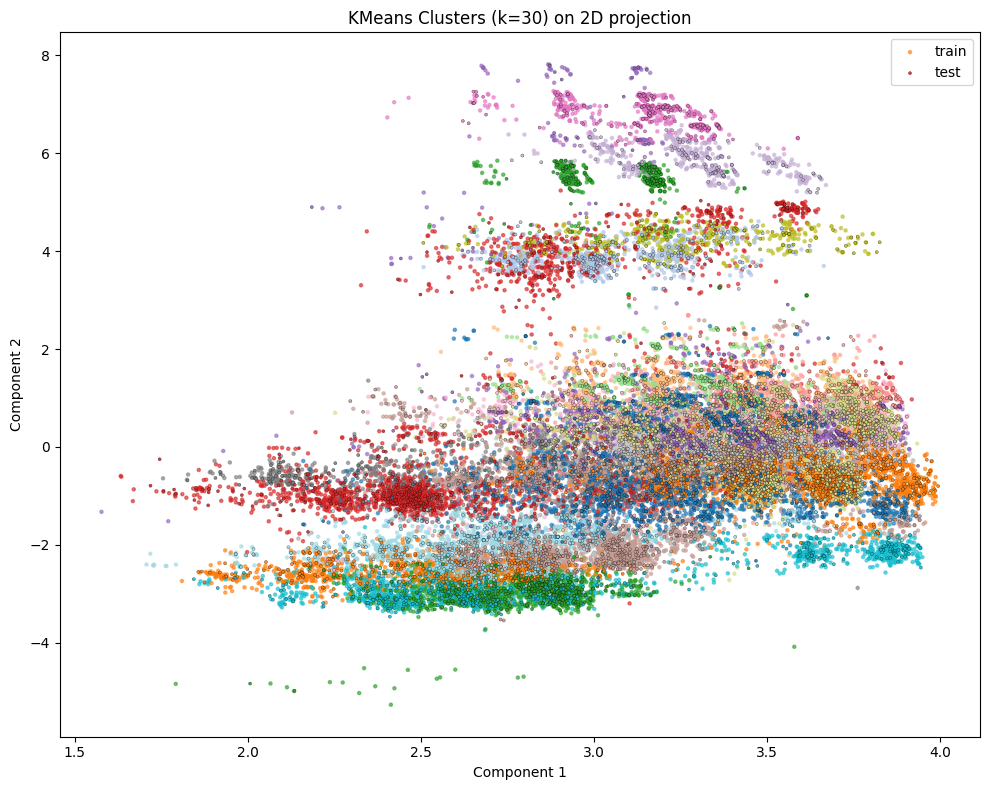

In [43]:
# KmEANS
plt.figure(figsize=(10, 8))

# training points
plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c=labels_train_km,
    cmap="tab20",
    s=5,
    alpha=0.6,
    label="train"
)
plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=labels_test_km,
    cmap="tab20",
    s=5,
    alpha=0.9,
    edgecolor="k",
    linewidth=0.2,
    label="test"
)

plt.title(f"KMeans Clusters (k={n_clusters}) on 2D projection")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

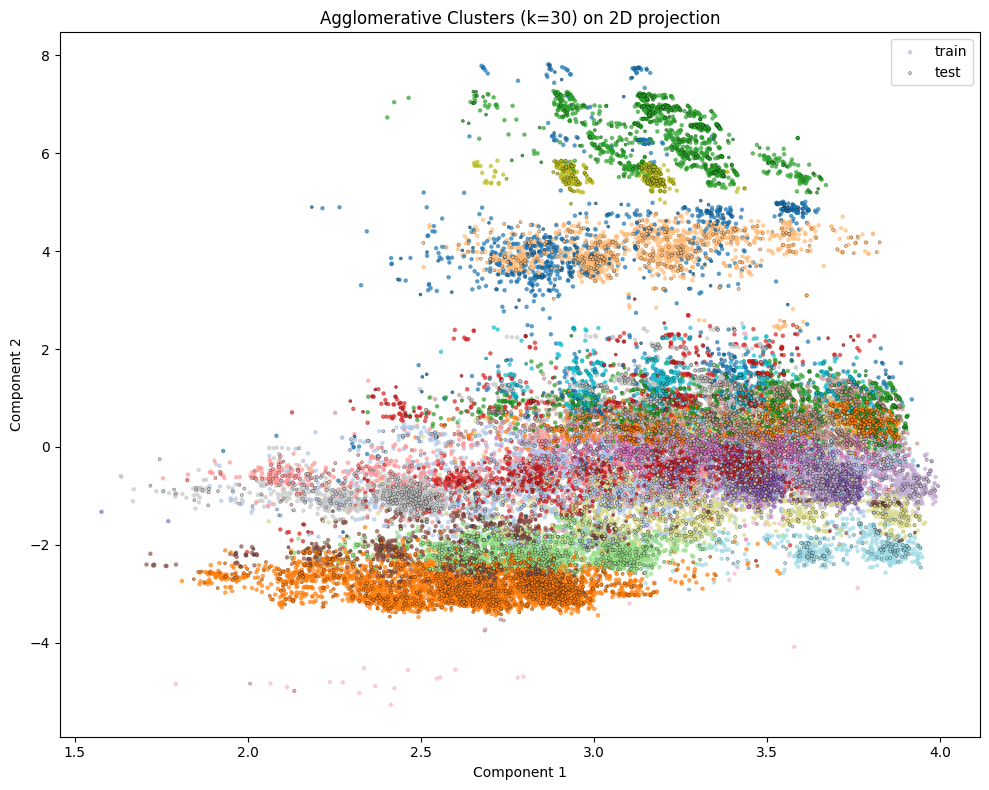

In [44]:
# Algo
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c=labels_train_agg,
    cmap="tab20",
    s=5,
    alpha=0.6,
    label="train"
)

plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=labels_test_agg,
    cmap="tab20",
    s=5,
    alpha=0.9,
    edgecolor="k",
    linewidth=0.2,
    label="test"
)

plt.title(f"Agglomerative Clusters (k={n_clusters}) on 2D projection")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [45]:
def category_precision(query_id, styles, recs, id_to_row):
    if recs is None or len(recs) == 0:
        return 0.0
    q_article = styles.iloc[id_to_row[query_id]]["articleType"]
    same_cat = recs[recs["articleType"] == q_article]
    return len(same_cat) / len(recs)

In [46]:
def cluster_precision(query_id, styles, recs, id_to_row, cluster_labels):
    if recs is None or len(recs) == 0:
        return 0.0
    q_cluster = cluster_labels[id_to_row[query_id]]
    rec_clusters = cluster_labels[recs.index]
    return (rec_clusters == q_cluster).mean()

In [47]:
def price_drift(query_id, styles, recs, id_to_row):
    if recs is None or len(recs) == 0:
        return float("nan")
    q_price = styles.iloc[id_to_row[query_id]]["effective_price"]
    median_price = recs["effective_price"].median()
    return abs(q_price - median_price)

In [49]:
def recommend_by_image(product_id, styles, img_embs_norm, id_to_row, topn=10):
    if product_id not in id_to_row:
        print("ID not found")
        return None

    i = id_to_row[product_id]
    query_vec = img_embs_norm[i].reshape(1, -1)
    sims = cosine_similarity(query_vec, img_embs_norm).ravel()

    # exclude itself
    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order].copy()
    recs["similarity_img"] = sims[order]
    return recs

In [50]:
def recommend_by_meta(product_id, styles, X_meta_text, id_to_row, topn=10):
    if product_id not in id_to_row:
        print("ID not found")
        return None

    i = id_to_row[product_id]
    query_vec = X_meta_text[i]
    sims = cosine_similarity(query_vec, X_meta_text).ravel()

    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order].copy()
    recs["similarity_meta"] = sims[order]
    return recs

In [51]:
def recommend_hybrid(product_id, styles, img_embs_norm, X_meta_text, id_to_row, alpha=0.6, topn=10):
    if product_id not in id_to_row:
        print("ID not found")
        return None

    i = id_to_row[product_id]

    img_sim = cosine_similarity(img_embs_norm[i].reshape(1,-1), img_embs_norm).ravel()
    meta_sim = cosine_similarity(X_meta_text[i], X_meta_text).ravel()
    sims = alpha * img_sim + (1 - alpha) * meta_sim

    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order].copy()
    recs["similarity_hybrid"] = sims[order]
    return recs

In [52]:
def evaluate_recommenders(query_id, styles, img_embs_norm, X_meta_text, id_to_row, cluster_labels, alpha=0.6, topn=10):
    
    # generate recommendations
    rec_img = recommend_by_image(query_id, styles, img_embs_norm, id_to_row, topn)
    rec_meta = recommend_by_meta(query_id, styles, X_meta_text, id_to_row, topn)
    rec_hybrid = recommend_hybrid(query_id, styles, img_embs_norm, X_meta_text, id_to_row, alpha, topn)

    # compute metrics
    results = {
        "image": {
            "category_precision": category_precision(query_id, styles, rec_img, id_to_row),
            "cluster_precision": cluster_precision(query_id, styles, rec_img, id_to_row, cluster_labels),
            "price_drift": price_drift(query_id, styles, rec_img, id_to_row),
        },
        "metadata": {
            "category_precision": category_precision(query_id, styles, rec_meta, id_to_row),
            "cluster_precision": cluster_precision(query_id, styles, rec_meta, id_to_row, cluster_labels),
            "price_drift": price_drift(query_id, styles, rec_meta, id_to_row),
        },
        "hybrid": {
            "category_precision": category_precision(query_id, styles, rec_hybrid, id_to_row),
            "cluster_precision": cluster_precision(query_id, styles, rec_hybrid, id_to_row, cluster_labels),
            "price_drift": price_drift(query_id, styles, rec_hybrid, id_to_row),
        }
    }
    
    return results, rec_img, rec_meta, rec_hybrid


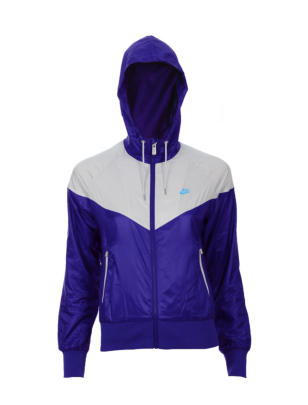

,category_precision,cluster_precision,price_drift
image,0.7,1.0,300.0
metadata,0.6,1.0,1000.0
hybrid,0.9,1.0,300.0


In [53]:
query_id = 10017   # pick any product
show_image(f'/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/{query_id}.jpg')
results, rec_img, rec_meta, rec_hybrid = evaluate_recommenders(
    query_id,
    styles,
    img_embs_norm,
    X_meta_text,
    id_to_row,
    cluster_labels,
    alpha=0.6,
    topn=10
)

import pandas as pd
pd.DataFrame(results).T

## Siamese Network


In [54]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm


In [55]:
# These should already exist from your previous work:
# styles: pd.DataFrame with one row per product
# img_embs_aligned: np.ndarray of shape (N, 512)
# X_meta_text: scipy sparse matrix or np.ndarray of shape (N, D_meta)

N = styles.shape[0]
print(styles.shape, img_embs_aligned.shape)


(43575, 55) (43575, 512)


In [56]:
from scipy import sparse

if sparse.issparse(X_meta_text):
    X_meta_dense = X_meta_text.astype(np.float32).toarray()
else:
    X_meta_dense = X_meta_text.astype(np.float32)

img_embs = img_embs_aligned.astype(np.float32)


In [57]:
# Build groups by articleType (only use articleTypes with at least 2 items)
group_col = "articleType"
styles[group_col] = styles[group_col].astype(str)

groups = {}
for idx, val in enumerate(styles[group_col].values):
    groups.setdefault(val, []).append(idx)

# Keep only groups with at least 2 items for positives
groups = {k: v for k, v in groups.items() if len(v) >= 2}
len(groups), list(groups)[:5]

(134, ['Skirts', 'Tshirts', 'Shorts', 'Track Pants', 'Caps'])

In [58]:
import random

class SiamesePairsDataset(Dataset):
    def __init__(self, img_embs, meta_embs, styles, groups, n_pairs=50000, same_prob=0.5):
        """
        img_embs: np.ndarray (N, 512)
        meta_embs: np.ndarray (N, D_meta)
        styles: pd.DataFrame
        groups: dict articleType -> list of indices
        n_pairs: total number of pairs to sample
        same_prob: probability that a sampled pair is positive (same type)
        """
        self.img_embs = img_embs
        self.meta_embs = meta_embs
        self.styles = styles.reset_index(drop=True)
        self.groups = groups
        self.n_pairs = n_pairs
        self.same_prob = same_prob

        self.indices = list(range(len(self.styles)))
        self.group_keys = list(groups.keys())

    def __len__(self):
        return self.n_pairs

    def _sample_positive_pair(self):
        # pick a group (articleType) and then two different items from it
        key = random.choice(self.group_keys)
        idxs = self.groups[key]
        i, j = random.sample(idxs, 2)
        return i, j, 1.0  # label 1

    def _sample_negative_pair(self):
        # pick two items from different groups
        # naive but fine for now
        key1, key2 = random.sample(self.group_keys, 2)
        i = random.choice(self.groups[key1])
        j = random.choice(self.groups[key2])
        return i, j, 0.0  # label 0

    def __getitem__(self, _):
        if random.random() < self.same_prob:
            i, j, label = self._sample_positive_pair()
        else:
            i, j, label = self._sample_negative_pair()

        img1 = self.img_embs[i]
        img2 = self.img_embs[j]
        meta1 = self.meta_embs[i]
        meta2 = self.meta_embs[j]

        return (
            torch.from_numpy(img1),
            torch.from_numpy(meta1),
            torch.from_numpy(img2),
            torch.from_numpy(meta2),
            torch.tensor(label, dtype=torch.float32),
        )


In [59]:
dataset = SiamesePairsDataset(img_embs, X_meta_dense, styles, groups, n_pairs=60000, same_prob=0.5)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)


In [60]:
class ProductEncoder(nn.Module):
    def __init__(self, dim_img=512, dim_meta=None, hidden_dim=512, out_dim=128):
        super().__init__()
        assert dim_meta is not None, "dim_meta must be provided"

        in_dim = dim_img + dim_meta
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, img_emb, meta_emb):
        x = torch.cat([img_emb, meta_emb], dim=1)
        z = self.net(x)
        z = F.normalize(z, p=2, dim=1)  # L2-normalize embeddings
        return z


In [61]:
def contrastive_loss(emb1, emb2, label, margin=1.0):
    """
    emb1, emb2: (B, D)
    label: (B,) 1 for similar, 0 for dissimilar
    """
    # Euclidean distance
    dist = F.pairwise_distance(emb1, emb2, p=2)

    # For positives (label=1): want dist^2 small
    # For negatives (label=0): want (margin - dist)^2 small if dist < margin
    loss_pos = label * dist.pow(2)
    loss_neg = (1 - label) * F.relu(margin - dist).pow(2)

    loss = (loss_pos + loss_neg).mean()
    return loss


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dim_meta = X_meta_dense.shape[1]
encoder = ProductEncoder(dim_img=img_embs.shape[1], dim_meta=dim_meta, hidden_dim=512, out_dim=128)
encoder = encoder.to(device)

optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-4)
n_epochs = 10


In [63]:
def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    n_batches = 0

    for img1, meta1, img2, meta2, label in loader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        meta1 = meta1.to(device)
        meta2 = meta2.to(device)
        label = label.to(device)

        with torch.set_grad_enabled(is_train):
            z1 = model(img1, meta1)
            z2 = model(img2, meta2)
            loss = contrastive_loss(z1, z2, label, margin=1.0)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches


In [64]:
for epoch in range(1, n_epochs + 1):
    train_loss = run_epoch(train_loader, encoder, optimizer)
    val_loss = run_epoch(val_loader, encoder, optimizer=None)
    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

# Save model
torch.save(encoder.state_dict(), "siamese_encoder.pt")


Epoch 01 | train loss: 0.0191 | val loss: 0.0058
Epoch 02 | train loss: 0.0066 | val loss: 0.0032
Epoch 03 | train loss: 0.0045 | val loss: 0.0019
Epoch 04 | train loss: 0.0037 | val loss: 0.0014
Epoch 05 | train loss: 0.0031 | val loss: 0.0014
Epoch 06 | train loss: 0.0030 | val loss: 0.0008
Epoch 07 | train loss: 0.0026 | val loss: 0.0007
Epoch 08 | train loss: 0.0025 | val loss: 0.0006
Epoch 09 | train loss: 0.0023 | val loss: 0.0007
Epoch 10 | train loss: 0.0022 | val loss: 0.0005


In [65]:
encoder.eval()

with torch.no_grad():
    img_tensor = torch.from_numpy(img_embs).float().to(device)
    meta_tensor = torch.from_numpy(X_meta_dense).float().to(device)

    batch_size = 256
    all_embs = []

    for i in range(0, len(styles), batch_size):
        img_batch = img_tensor[i:i+batch_size]
        meta_batch = meta_tensor[i:i+batch_size]

        z = encoder(img_batch, meta_batch)
        all_embs.append(z.cpu().numpy())

    style_embs = np.vstack(all_embs)  # shape (N, 128)



In [66]:
# Save embeddings
np.save("siamese_embeddings.npy", style_embs)

# Save product IDs (critical!)
ids = styles["id"].values
np.save("siamese_ids.npy", ids)


In [67]:
from sklearn.metrics.pairwise import cosine_similarity

# build id_to_row again if needed
id_to_row = {pid: idx for idx, pid in enumerate(styles["id"].values)}

def recommend_siamese(product_id, styles, style_embs, id_to_row, topn=10):
    if product_id not in id_to_row:
        raise ValueError("Unknown product id")

    i = id_to_row[product_id]
    query_vec = style_embs[i].reshape(1, -1)
    sims = cosine_similarity(query_vec, style_embs).ravel()

    order = sims.argsort()[::-1]
    order = [idx for idx in order if idx != i][:topn]

    recs = styles.iloc[order].copy()
    recs["similarity_siamese"] = sims[order]
    return recs


In [68]:
print(styles.shape)       # (N, ...)
style_embs.shape 

(43575, 55)


(43575, 128)

In [69]:
style_embs = np.array(style_embs) 

In [70]:
np.save("style_embeddings_siamese.npy", style_embs)

In [71]:
style_embs = np.load("style_embeddings_siamese.npy")

In [72]:
styles["id"] = styles["id"].astype(int)  # just to be safe
id_to_row = {int(pid): idx for idx, pid in enumerate(styles["id"].values)}

In [73]:
test_id = int(styles["id"].iloc[0])  # first product
test_id  # see what it is

10000

In [74]:
test_id = 10000
if test_id not in id_to_row:
    raise ValueError("test_id not in styles['id']")

In [75]:
recs_siamese = recommend_siamese(
    product_id=test_id,
    styles=styles,
    style_embs=style_embs,
    id_to_row=id_to_row,
    topn=10
)

recs_siamese.head()

,id,price,myntraRating,brandName,ageGroup,gender,baseColour,colour1,fashionType,season,...,era,season_bucket,segment,style_signature,season_group,category_strength,cluster_meta,cluster_kmeans,cluster_agg,similarity_siamese
1,10001,549.0,1,Palm Tree,kids-girls,women,blue,Unknown,Fashion,summer,...,2011-2015,warm,women_kidsgirls,women Bottomwear Skirts blue Printed Unknown U...,warm,128,8,21,11,0.999946
2,10002,549.0,1,Palm Tree,kids-girls,women,blue,Unknown,Fashion,summer,...,2011-2015,warm,women_kidsgirls,women Bottomwear Skirts blue Printed Unknown U...,warm,128,8,21,11,0.999944
40936,6864,3000.0,1,Forever New,adults-women,women,white,Pink,Fashion,summer,...,2011-2015,warm,women_adultswomen,women Bottomwear Skirts white Printed Polyeste...,warm,128,29,1,2,0.999906
42333,8501,2800.0,1,Forever New,adults-women,women,blue,Unknown,Fashion,fall,...,2011-2015,cold,women_adultswomen,women Bottomwear Skirts blue Solid Silk Blend ...,cold,128,29,1,2,0.999906
2736,13264,599.0,1,Palm Tree,kids-girls,women,pink,Unknown,Fashion,fall,...,2011-2015,cold,women_kidsgirls,women Bottomwear Skirts pink Solid Cotton Blen...,cold,128,8,21,11,0.999904


## Evaluation

In [76]:
def compute_relevance(q, c):
    """
    q, c are rows from styles DataFrame (pd.Series).
    Returns a numeric relevance score (0+).
    """
    score = 0

    # strong signals
    if q.get("articleType") == c.get("articleType"):
        score += 3
    if q.get("subCategory") == c.get("subCategory"):
        score += 2

    # medium signals
    if q.get("masterCategory") == c.get("masterCategory"):
        score += 1
    if q.get("gender") == c.get("gender"):
        score += 1
    if q.get("segment") == c.get("segment"):
        score += 1

    # softer signals
    if q.get("price_bucket") == c.get("price_bucket"):
        score += 1
    if q.get("season_group", q.get("season")) == c.get("season_group", c.get("season")):
        score += 1
    if q.get("usage") == c.get("usage"):
        score += 1

    # optional brand
    if q.get("brandName") == c.get("brandName"):
        score += 1

    return score

In [77]:
def is_relevant(q, c, threshold=4):
    return compute_relevance(q, c) >= threshold


In [78]:
import numpy as np
import pandas as pd
from collections import defaultdict

def eval_model_on_queries(
    model_name,
    recommend_fn,      # function(product_id, topn=K) -> df with 'id'
    styles,
    query_ids,
    K=10
):
    metrics = defaultdict(list)

    for pid in query_ids:
        if pid not in id_to_row:
            continue
        q_idx = id_to_row[pid]
        q_row = styles.iloc[q_idx]

        recs = recommend_fn(pid, topn=K)
        if recs is None or len(recs) == 0:
            continue

        # join to get full rows
        rec_rows = styles.merge(recs[["id"]], on="id", how="inner")
        if rec_rows.empty:
            continue

        # compute relevance scores
        rel_scores = [compute_relevance(q_row, r) for _, r in rec_rows.iterrows()]
        rel_scores = np.array(rel_scores)

        # binary relevance
        rel_bin = (rel_scores > 0).astype(int)
        # OR use is_relevant(q, r, threshold=4) for stricter definition

        # Precision@K (using rel>0)
        prec = rel_bin.mean()
        metrics["precision_at_k"].append(prec)

        # Price drift
        if "effective_price" in styles.columns:
            q_price = q_row["effective_price"]
            rec_prices = rec_rows["effective_price"].values
            price_drift = np.mean(np.abs(rec_prices - q_price))
            metrics["price_drift"].append(price_drift)

        # Category precision (same articleType)
        same_type = (rec_rows["articleType"].values == q_row["articleType"]).mean()
        metrics["category_precision"].append(same_type)

        # NDCG@K using rel_scores as graded relevance
        # DCG
        gains = (2**rel_scores - 1) / np.log2(np.arange(2, len(rel_scores) + 2))
        dcg = gains.sum()

        # ideal DCG
        sorted_rel = np.sort(rel_scores)[::-1]
        ideal_gains = (2**sorted_rel - 1) / np.log2(np.arange(2, len(sorted_rel) + 2))
        idcg = ideal_gains.sum() if ideal_gains.sum() > 0 else 1.0
        ndcg = dcg / idcg
        metrics["ndcg_at_k"].append(ndcg)

    # aggregate
    results = {f"{model_name}_{m}": np.mean(v) for m, v in metrics.items() if len(v) > 0}
    return results


In [79]:
all_ids = styles["id"].values
np.random.seed(42)
query_ids = np.random.choice(all_ids, size=500, replace=False)

In [80]:
results = {}

results.update(
    eval_model_on_queries(
        "image",
        lambda pid, topn=10: recommend_by_image(pid, styles, img_embs_norm, id_to_row, topn=topn),
        styles,
        query_ids,
        K=10,
    )
)

results.update(
    eval_model_on_queries(
        "meta",
        lambda pid, topn=10: recommend_by_meta(pid, styles, X_meta_text, id_to_row, topn=topn),
        styles,
        query_ids,
        K=10,
    )
)

results.update(
    eval_model_on_queries(
        "hybrid",
        lambda pid, topn=10: recommend_hybrid(pid, styles, img_embs_norm, X_meta_text, id_to_row, alpha=0.6, topn=topn),
        styles,
        query_ids,
        K=10,
    )
)

results.update(
    eval_model_on_queries(
        "siamese",
        lambda pid, topn=10: recommend_siamese(pid, styles, style_embs, id_to_row, topn=topn),
        styles,
        query_ids,
        K=10,
    )
)

# if you have a cluster-based recommender:
# results.update(...)

pd.Series(results).sort_index()

hybrid_category_precision       0.957800
hybrid_ndcg_at_k                0.882754
hybrid_precision_at_k           1.000000
hybrid_price_drift            366.151000
image_category_precision        0.858400
image_ndcg_at_k                 0.787351
image_precision_at_k            1.000000
image_price_drift             542.722002
meta_category_precision         0.980200
meta_ndcg_at_k                  0.925896
meta_precision_at_k             1.000000
meta_price_drift              319.815000
siamese_category_precision      0.998200
siamese_ndcg_at_k               0.856971
siamese_precision_at_k          1.000000
siamese_price_drift           541.692000
dtype: float64